In [2]:
from math import pi
import pandas as pd
import numpy as np
import requests
import base64
import json
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import time

In [3]:
# initialize and authorize SpotipyOAuth 

usn = 'h_vy'
cid = '24da2914fefb43e198bf76d87e121f9c'
csc = '79bc72fb858041078caac075f9c369dd'
rur = 'http://localhost'
scp = 'user-read-private'

oam = spotipy.oauth2.SpotifyOAuth(username=usn, scope=scp, client_id=cid, client_secret=csc, redirect_uri=rur)
spo = spotipy.Spotify(oauth_manager=oam)

In [20]:
# feature categories
cat = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# shorten category names by taking first 4 characters
cat_sh = [c[:4] for c in cat]
# indices of feature categories
cat_ind = [1, 2, 4, 7, 8, 9, 10, 11]

In [7]:
# tracks of Fav playlist
fav_tracks = spo.playlist_tracks('2LlQtAk2KbOAGqgPwOUn9J')

In [34]:
"""
build and return a DataFrame of Track IDs and Names of Playlist Tracks
:trackJson: JSON Response, or Python dict, of Playlist Tracks
"""
def getTrackDf(trackJson):
    tracks = []
    for i in fav_tracks['items']:
        track = []
        track.append(i['track']['id'])
        track.append(i['track']['name'])
        track.append(i['track']['artists'][0]['name'])
        tracks.append(track)
    df = pd.DataFrame(data=tracks, columns=['id', 'name', 'artist'])
    df.set_index('id')
    return df

"""
build and return a DataFrame of Features of Multiple Tracks that 
include all features, track names and track IDs
:trackDf: list of track IDs 
:trackJson: JSON Response/Python dict of Tracks
"""
def getFeatureDf(featuresJson):
    featureDf = pd.DataFrame(featuresJson).set_index('id')

    # drop irrelevant columns
    featureDf.drop(['type', 'uri','track_href','analysis_url'], axis=1, inplace=True)

    # rescaling loudness
    minx = -60
    maxx = 0
    featureDf.insert(loc=3, column='norm_loudness', value=(featureDf['loudness']-minx)/(maxx-minx))
    featureDf.rename(columns={'loudness':'raw_loudness', 'norm_loudness':'loudness'}, inplace=True)

    return featureDf

In [27]:
trackDf = getTrackDf(fav_tracks)

In [28]:
favIds = trackDf.id.tolist()

In [29]:
fav_ft = spo.audio_features(favIds)

In [36]:
featureDf = getFeatureDf(fav_ft)

In [37]:
fullFtDf = pd.merge(featureDf, trackDf, left_on='id', right_on='id')

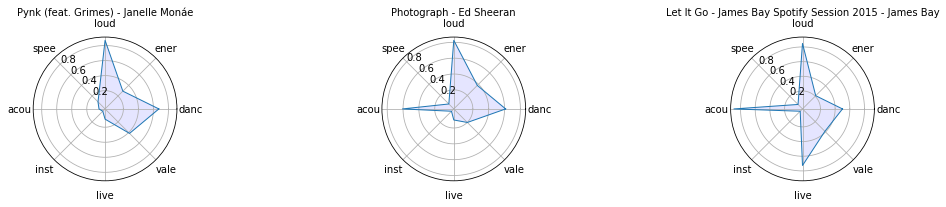

In [99]:
nrows, ncols = 1, 3

# initialize the radar graph for multiple track
fig, axs = plt.subplots(nrows, ncols, subplot_kw=dict(polar=True), figsize=(ncols*5, nrows*3))
plt.subplots_adjust(wspace=0.1)

# initialize indices for Axes list
if nrows != 1: 
    l = [(x, y) for x in range(nrows) for y in range(ncols)]
else: l = [y for y in range(ncols)]

# graph
for i, row in zip(l, fullFtDf.loc[[5, 7, 9]].iterrows()):
    # list of categories
    n = len(cat)
    trackFt = row[1][cat].values.tolist()
    
    # duplicate first value to close the plot
    trackFt += trackFt[:1]

    angles = [i / float(n) * 2 * pi for i in range(n)]
    angles += angles[:1]

    # configure axes
    ax = axs[i]
    thetaticks = np.arange(0,360,45)
    ax.set_thetagrids(thetaticks, labels=cat_sh, fontsize=10)
    ax.set_rlabel_position(135)
    ax.set_title(pad=15, fontdict={'fontweight':'book'}, label=row[1][-2]+ " - " + row[1][-1], size=10)
    ax.set_rticks(np.arange(0.2,0.8,0.2))
    ax.set_rmax(20)
    
    # plot and fill
    ax.plot(angles, trackFt, linewidth=1, linestyle='solid')
    ax.fill(angles, trackFt, 'b', alpha=0.1)

#plt.suptitle('Features of Favorite Tracks', weight='semibold', size=13)
plt.tight_layout()
plt.savefig(fname='../docs/assets/img/tracks.png', dpi='figure', bbox_inches='tight')
plt.show()

In [83]:
fullFtDf.loc[:10]

,id,danceability,energy,key,loudness,raw_loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,artist
0,0830WmzxBqOp9C93j8m9sN,0.619,0.394,5,0.837550,-9.747,1,0.0444,0.0472,0.020000,0.1000,0.123,124.000,319750,4,Sign Of The Times - Spotify Studios NYC,LANY
1,1lhdtLh7c6Y21O36qxCXxD,0.531,0.317,1,0.824100,-10.554,1,0.0260,0.8160,0.000001,0.1130,0.302,149.917,291651,3,Và Thế Là Hết,Chillies
2,1zVhMuH7agsRe6XkljIY4U,0.439,0.489,8,0.895233,-6.286,1,0.0368,0.1320,0.000643,0.1140,0.253,143.808,250707,4,human,Christina Perri
3,69vToJ9BMbbLlFZo7k7A7B,0.331,0.235,10,0.871667,-7.700,1,0.0299,0.9180,0.000000,0.1370,0.218,171.232,204326,3,You Are The Reason,Calum Scott
4,5A1w94uzc1kO1Zhe8WWxC3,0.788,0.427,5,0.834700,-9.918,0,0.3080,0.0649,0.000036,0.1710,0.605,97.038,215227,4,Right Back,Khalid
5,5OpiyfqaQLdtwHd3SfembH,0.672,0.291,8,0.869283,-7.843,1,0.0897,0.0375,0.000004,0.0925,0.417,100.961,240426,4,Pynk (feat. Grimes),Janelle Monáe
6,1CI6YgwwNq3VfhgxPuEpE6,0.699,0.524,11,0.874633,-7.522,1,0.0510,0.4120,0.000000,0.0844,0.310,114.922,289133,4,Ride,SoMo
7,1HNkqx9Ahdgi1Ixy2xkKkL,0.614,0.379,4,0.825333,-10.480,1,0.0476,0.6070,0.000464,0.0986,0.201,107.989,258987,4,Photograph,Ed Sheeran
8,3xRcQ04b0l5RiU2w7lJhCD,0.549,0.413,4,0.906883,-5.587,1,0.0362,0.7560,0.000000,0.0939,0.290,139.981,225920,4,Bad,James Bay
9,4tYokojnBEp5pBWO7wTRPA,0.500,0.210,1,0.847967,-9.122,1,0.0416,0.8900,0.000012,0.7260,0.387,140.401,285867,3,Let It Go - James Bay Spotify Session 2015,James Bay


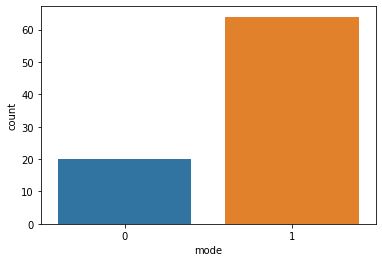

In [159]:
# count songs in Major vs Minor mode
sns.countplot(x='mode', data=fullFtDf)
plt.show()